## Series: Credit Card Fraud
### Tutorial 2: Generating and Evaluating a Feature Hypothesis

**Tags: Foundations, Feature hypotheses, Iterating on a model**

In Tutorial 1 we looked at a basic model for credit card fraud, using the kaggle dataset https://www.kaggle.com/dalpozz/creditcardfraud. This was a nice easy step into enterprise ML use cases because it represents a core component of the type of data product that is valuable in almost all enterprise contexts- prioritized lists. This is the typical way to insert data into an operational workflow in a seamless manner.

But we obviously shouldn't consider these models to be stationary. More data will come in over time, our users or adversaries will adjust their behavior, and, most importantly, we'll learn more and more about how our business actually works. In the first two cases we might need only periodic refits, as they represent only updates of information to the same foundation. In the last case, however, we take into account that we might have learned a thing or two about what we're doing- how our business operates, what levers it has, or what new data it might be able to generate. In these scenarios, we will want to update our model construct itself, to take advantage of our new understanding. So how do we go about this? The process I will advocate for here I call the "ML iteration loop". It powers a process of continuous improvement and the faster you cycle through it the faster your models improve.

1. Generate a hypothesis, based on your domain expertise.
2. Generate evidence for the hypothesis on your training data.
3. If the evidence supports the hypothesis, aggregate the data/build the feature set that can represent the hypothesis in the model.
4. Refit the model. If performance boost, then deploy, else evaluate other merits (eg. Is the new model simpler? More stable? Have more explanatory power?) and decide.

In this Tutorial, I'd like to run through an illustrative example of this process in action, using Time as our feature of choice.

### Step 1: Generate a Hypothesis

Recall that in the Tutorial 1 we chose not to include Time in our feature set. The reason for that was that Time is a unique feature:
- it is monotonically increasing
- effects on other variables can only run forward
- noise in other variables tends to build as it increases

among others. Because of this, it wouldn't have been appropriate to include Time naively in our models. Rather, we need to have a working hypothesis for how time should enter into the process we are trying to predict (of note, there are many processes that are time invariant and in those cases time should be explicitly excluded).

In our current case we are looking to identify fraudulent transactions. Thinking about the generating process here, fraudulent transactions are generated by fraudsters. So what if a given fraudster or group of fraudsters attacked us in bunches? Ie. What if fraudsters tried to generate a bunch of transactions over a short period of time? Thus we have our hypothesis.

### Step 2: Generate Evidence

If our hypothesis is true, we would expect that fraudulent transactions would come in bunches, and that a given transaction might be more likely to be fraudulent if it is close in time to transactions that were flagged as fraud. This gives us a hook into our data, to generate some evidence for or against our hypothesis. So let's go write some code.

In [2]:
%matplotlib inline

import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# We're going to use this to time some things
import tqdm

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
# Load the data. Don't forget to change this variable to your dataset location.
credit_dataset_location = '/Users/ianblumenfeld/data/credit_card_fraud/creditcard.csv'
data = pd.read_csv(credit_dataset_location)

In [4]:
# As before, we'll make a copy to use
df = data.copy()

The most expedient way to pressure test our hypothesis is by generating a heuristic that maps our data onto it. In this case we'll do the following:
1. Iterating through our training data, for each data point, create a data set of records from the previous 10 time periods- their associated window.
2. Sum up the number of fraudulent records in the created data set, and attach it as a feature to our data.
3. Calculate the percentage of fraudulent records for those that had at least one fraudulent record in their associated dataset vs. those that did not. 
4. If the fraud rate in those with fraud in their window is higher than those without, we consider that we have directional evidence for our "bunchiness" hypothesis and we'll try to add it our models. Otherwise we do not.

Note that the choice of 10 time periods is arbitrary. We could have chosen 5, 50, even 500. However, this is a place where machine learning differs from causal inference or theoretical physics- we can't reach an absolutely correct result. The No Free Lunch Theorem tells us that a heuristic that performs "good enough" is the best we can do. Thus if we'd like to improve, we should be searching for the best one based on performance metrics related to our business needs. In practice, finding the first thing that works tends to be much more valuable than tuning said heuristic after it's been found for a significant amount of time. This is because tuning yields diminishing returns, especially relative to finding new hypothesese to test. 

In [6]:
# Create a list of the heuristic value for each record.
heuristic_values = []
# We'll time this loop. It takes a while which is a thing we'll come back to.
for i in tqdm.tqdm(df.index):
    val = df[(df.Time<df.iloc[i].Time) & (df.Time>=(df.iloc[i].Time-10))].Class.sum()
    heuristic_values.append(val)

100%|██████████| 284807/284807 [14:23<00:00, 329.82it/s]


So as we expected this loop took a while. This obviously represents a problem if we want to make use of this feature for more work at a later date. Or if we decided we'd like to modify it. There are some ways we can speed it up (through vectorization, eg.), but we'll actually come back to this in a subsequent post with a different approach, utilizing a database for building a feature store, something we'll need anyways for our work to be repeatable.

Returning to the problem at hand, we can now add the heuristic values as a feature in our dataset.

In [7]:
df['num_fraud_in_associated_window'] = heuristic_values
df['had_fraud_in_associated_window'] = np.array(heuristic_values)>0

Before we check the fraud rate for our two classes (had fraud in the associated window vs. did not), we need to split our data into the training, testing, and validation data. If we don't do so, and check the heuristic on the full dataset we have effectively polluted our analysis and model build by allowing information from the validation set into the training process. Much badness tends to ensue in these scenarios.

In [8]:
# As before, we'll use the last 75K points for validation.
df['validation_set'] = df.index>df.shape[0]-75000
df_val = df[df.validation_set==True].copy()

# The earlier data we'll use for model training.
df_test_train = df[df.validation_set==False].copy()

In [12]:
# We'll generate the random split.
x_train, x_test = train_test_split(df_test_train, test_size=0.33, random_state=15)

In [13]:
# Examining the training set, we can see our new feature available.
x_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,num_fraud_in_associated_window,had_fraud_in_associated_window,validation_set
54413,46440.0,1.043152,-0.014368,0.234844,1.244115,0.019931,0.344975,0.033729,0.133630,0.037275,...,-0.295573,0.659468,-0.315173,0.026232,0.011719,61.00,0,0,False,False
39704,39930.0,-0.550111,-0.173865,1.647397,-0.753729,-0.157741,-0.997432,0.402301,-0.234459,-1.842091,...,0.472098,0.129285,-0.323370,-0.161022,-0.158018,49.49,0,0,False,False
53013,45773.0,1.126978,0.314222,0.385173,0.998461,-0.045971,-0.262269,0.121079,-0.019052,-0.445162,...,0.264050,0.587558,-0.333059,0.031391,0.012551,13.52,0,0,False,False
82311,59355.0,-0.953601,-0.691997,1.612222,-1.803030,-2.214743,-0.084287,-0.476875,0.173687,-1.808626,...,0.351591,-0.835747,-0.357699,-0.211048,-0.166016,152.65,0,0,False,False
21975,31966.0,1.568981,-0.660334,-0.136480,-1.353745,-0.985982,-1.315005,-0.347411,-0.507443,-2.426676,...,0.431909,0.734602,-0.087895,0.007436,0.009205,10.00,0,0,False,False


In [28]:
# Now we'll generate the relevant summary statistics.
probs = x_train[['Class', 'had_fraud_in_associated_window']].groupby('had_fraud_in_associated_window').agg([sum, len])
probs = probs['Class']
print('Percentage of fraudulent records with no fraud in associated window: %f' % (probs['sum']/probs['len']*100).loc[False])
print('Percentage of fraudulent records with fraud in associated window: %f' % (probs['sum']/probs['len']*100).loc[True])

Percentage of fraudulent records with no fraud in associated window: 0.166535
Percentage of fraudulent records with fraud in associated window: 1.010101


From this we see that there is a 6x jump in the fraud rate when the record has fraud in the associated window. To be sure we should check the error bars. To do so we'll use the binomial errors.

$$95\% EB = \small{+/-}1.96*\sqrt{\frac{P*(1-P)}{n}}$$

In [36]:
p_false = (probs['sum']/probs['len']).loc[False]
p_true = (probs['sum']/probs['len']).loc[True]
n_false = probs['len'].loc[False]
n_true = probs['len'].loc[True]
eb_false = 1.96*np.sqrt((p_false*(1-p_false))/n_false)
eb_true = 1.96*np.sqrt((p_true*(1-p_true))/n_true)

In [101]:
print("Error bars around percentage with no fraud in associated window: (%f, %f)" % ((p_false-eb_false)*100
                                                                                  , (p_false+eb_false)*100))
print("Error bars around percentage with fraud in associated window: (%f, %f)" % ((p_true-eb_true)*100
                                                                                  , (p_true+eb_true)*100))

Error bars around percentage with no fraud in associated window: (0.144936, 0.188134)
Error bars around percentage with fraud in associated window: (0.686272, 1.333930)


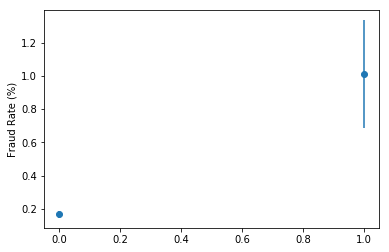

In [78]:
# Let's plot this.
plt.errorbar([False, True], [p_false*100, p_true*100], 
             yerr=[eb_false*100, eb_true*100], 
             fmt='o')
plt.ylabel('Fraud Rate (%)')
plt.xlabel('')

The edges of the error bars don't touch, so we've now got very strong evidence for our bunching hypothesis and we can add the related features into our models. In particular we'll add:
- had_fraud_in_associated_window and
- number_fraudulent_records_in_associated_window.

Note that this does not mean that either of these features will be accepted, nor that, if they are, that their contribution will be as strong as the analysis we did above would indicate. This is due to the fact that the time based contribution might be heavily correlated with or even entirely represented by the features we already have available. We'll allow the models themselves to sort that out.

In [87]:
# Create the datasets, stripping out the unneeded columns.
cols = [col for col in x_train.columns if col not in ['Class', 'group', 'Time', 'validation_set']]
features_train = x_train[cols]
labels_train = x_train[['Class']]
features_test = x_test[cols]
labels_test = x_test[['Class']]
features_validate = df_val[cols]
labels_validate = df_val[['Class']]

In [55]:
lr_model = LogisticRegression(penalty='l1',).fit(features_train, np.ravel(labels_train))

In [58]:
auc_train = metrics.roc_auc_score(labels_train, lr_model.predict_proba(features_train.values)[:,1])
auc_test = metrics.roc_auc_score(labels_test.values, lr_model.predict_proba(features_test.values)[:,1])
auc_val = metrics.roc_auc_score(labels_validate, lr_model.predict_proba(features_validate.values)[:,1])
print('AUC for the training set: %f' % auc_train)
print('AUC for the training set: %f' % auc_test)
print('AUC for the validation set: %f' % auc_val)

AUC for the training set: 0.978290
AUC for the training set: 0.979729
AUC for the validation set: 0.968051


The new model performs on par with the old. So how would we decide if we wanted to deploy it? One thing we could do is check the contribution of the new feature. The fact that we are using L1 regularization helps with this, as it will zero out features it doesn't need. Taking a look at the feature strengths:

In [59]:
[str(tup) for tup in zip(features_train.columns, lr_model.coef_.tolist()[0])]

["('V1', 0.09047007062501142)",
 "('V2', 0.04479933765342518)",
 "('V3', 0.013423779816884272)",
 "('V4', 0.6237816402878651)",
 "('V5', 0.07411862770269553)",
 "('V6', -0.11678986205366357)",
 "('V7', -0.1303942585674241)",
 "('V8', -0.15317775237915313)",
 "('V9', -0.2512701867755234)",
 "('V10', -0.7781835673050289)",
 "('V11', -0.0724021298194891)",
 "('V12', 0.09860457619419156)",
 "('V13', -0.08950085501623094)",
 "('V14', -0.5567971456493922)",
 "('V15', -0.005031498943219253)",
 "('V16', -0.02856317759488419)",
 "('V17', -0.005183577820944473)",
 "('V18', 0.01734862090105411)",
 "('V19', 0.05219703539383706)",
 "('V20', -0.4569612142793407)",
 "('V21', 0.41522023017911763)",
 "('V22', 0.6899979560701862)",
 "('V23', -0.21182284676605734)",
 "('V24', -0.14068581616109432)",
 "('V25', 0.0)",
 "('V26', 0.22811908287349245)",
 "('V27', -0.8246232428238774)",
 "('V28', -0.2593428462475945)",
 "('Amount', 0.0010179986002064165)",
 "('num_fraud_in_associated_window', 0.0)",
 "('had_fr

We can see that the "number of fraudulent records in the associated window" feature has been dropped by the model, but that the "had fraud in associated window" was kept, and has one of the larger contributions to the calculation. Coupling this with the explanatory evidence we generated above would give us justfication to deploy this version vs. the previous one (we may consider ensembling as well, but we'll leave that for a later date).

Let's take a look at the deep model as well.

In [79]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l1_l2

Using TensorFlow backend.


In [80]:
# Upweight the fraudulent data points.
class_weight = {0:1, 1:499}

In [91]:
# The model.

num_units=50

reg = l1_l2()

deep_model = Sequential()

# Layer 1
deep_model.add(Dense(num_units, input_dim=features_train.shape[1], 
                kernel_regularizer=reg, 
                activation='relu'))
deep_model.add(Dropout(0.2))

# Layer 2
deep_model.add(Dense(num_units, 
                kernel_regularizer=reg, 
                activation='relu'))
deep_model.add(Dropout(0.2))

# Layer 3
deep_model.add(Dense(num_units, 
                kernel_regularizer=reg, 
                activation='relu'))
deep_model.add(Dropout(0.2))

# Output
deep_model.add(Dense(1, activation='sigmoid'))

In [92]:
# Still using adagrad and binary cross entropy
deep_model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])

In [93]:
deep_model.fit(
    features_train.values, 
    labels_train.values, 
    batch_size=1024, 
    epochs=100,
    verbose=1, 
    class_weight=class_weight, 
    validation_data=(features_test.values, labels_test.values))

Train on 140571 samples, validate on 69237 samples
Epoch 1/100
140571/140571 [==============================] - 5s - loss: 8.3273 - acc: 0.7737 - val_loss: 4.4097 - val_acc: 0.9895
Epoch 2/100
140571/140571 [==============================] - 3s - loss: 6.0967 - acc: 0.8028 - val_loss: 3.8877 - val_acc: 0.9846
Epoch 3/100
140571/140571 [==============================] - 3s - loss: 5.2168 - acc: 0.8479 - val_loss: 3.7722 - val_acc: 0.9649
Epoch 4/100
140571/140571 [==============================] - 3s - loss: 4.8120 - acc: 0.8800 - val_loss: 3.4512 - val_acc: 0.9842
Epoch 5/100
140571/140571 [==============================] - 3s - loss: 4.7376 - acc: 0.8711 - val_loss: 3.3557 - val_acc: 0.9814
Epoch 6/100
140571/140571 [==============================] - 3s - loss: 4.3733 - acc: 0.9012 - val_loss: 3.2001 - val_acc: 0.9880
Epoch 7/100
140571/140571 [==============================] - 4s - loss: 4.3808 - acc: 0.8987 - val_loss: 3.5113 - val_acc: 0.8723
Epoch 8/100
140571/140571 [============

In [94]:
deep_auc_train = metrics.roc_auc_score(labels_train.values, deep_model.predict_proba(features_train.values))
deep_auc_test = metrics.roc_auc_score(labels_test.values, deep_model.predict_proba(features_test.values))
deep_auc_val = metrics.roc_auc_score(labels_validate.values, deep_model.predict_proba(features_validate.values))
print()
print('AUC for the training set: %f' % deep_auc_train)
print('AUC for the training set: %f' % deep_auc_test)
print('AUC for the validation set: %f' % deep_auc_val)

73440/74999 [============================>.] - ETA: 0s
AUC for the training set: 0.977823
AUC for the training set: 0.985993
AUC for the validation set: 0.976827


Once again, the model performance is effectively the same with this new feature set. We can thus choose whether or not to deploy based on other factors.

To finish off, note 3 things that we'll focus on in a subsequent set of posts:
1. We constructed a specific heuristic to use for our bunching hypothesis in an ad hoc manner. Are there any algorithmic approaches we could take to optimize this for us? This would improve our model performance while at the same time freeing our cognitive load for further hypothesis generation- a win/win.
2. As noted above, the feature generation calculations we ran through were fairly time consuming. This would make it hard to continue operating as we have been, where we load the raw dataset at the start each time. We could (and likely would eventually) spend some time optimizing this, but are there alternatives? In particular we might consider leveraging storage solutions so we can cache some of our calculated results. This offers ancillary benefits as well, such as a way to generate reproducibility.
3. In doing the related activities in Tutorials 1 and 2, we needed to copy and past *A LOT* of code. This will tend to make our solutions brittle and error prone, and also difficult to share/collaborate on. How can we address this type of issue?

More next time...